In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [161]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2  = nn.Conv2d(8, 12, 3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)
        self.conv3  = nn.Conv2d(12, 16, 3, padding=1)
        self.conv4  = nn.Conv2d(16, 20, 3, padding=1)
        self.pool2  = nn.MaxPool2d(2, 2) 

        self.fc1    = nn.Linear(20*7*7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)

        x = x.view(-1, 20*7*7)
        x = self.fc1(x)
        return x

use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = Network().to(device)
total_parameters = sum(p.numel() for p in model.parameters())
print(f"Total Parameters : {total_parameters}")
print(model)
      

Total Parameters : 15410
Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=980, out_features=10, bias=True)
)


In [162]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #  transforms.RandomApply([transforms.CenterCrop(22)], p=0.1),
                        #  transforms.Resize((28, 28)),
                         #transforms.RandomRotation((-15., 15.)),
                         transforms.RandomRotation(15),
                        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [177]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

Output shape after Conv2: torch.Size([128, 20, 14, 14])
(128, 20, 14, 14)


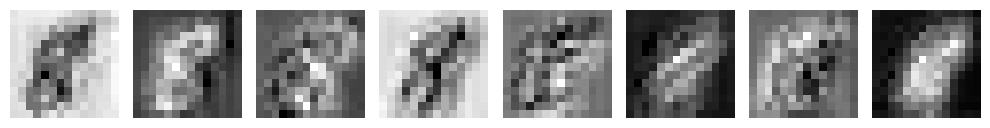

In [181]:
import matplotlib.pyplot as plt

intermediate_outputs = {}

def hook_fn(module, input, output):
    intermediate_outputs[module] = output

model = Network()
hook1 = model.conv1.register_forward_hook(hook_fn)
hook2 = model.conv2.register_forward_hook(hook_fn)
hook3 = model.pool1.register_forward_hook(hook_fn)
hook4 = model.conv3.register_forward_hook(hook_fn)
hook5 = model.conv4.register_forward_hook(hook_fn)


output = model(images)
print("Output shape after Conv2:", intermediate_outputs[model.conv4].shape)
#hook1.remove()

# Get feature map from conv1
feature_map = intermediate_outputs[model.conv4].detach().cpu().numpy()
print(feature_map.shape)

# Plot the feature maps
fig, axes = plt.subplots(1, 8, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    if i < feature_map.shape[1]:  # Number of channels in the feature map
        ax.imshow(feature_map[0, i], cmap='gray')  # Show one channel
        ax.axis('off')
plt.tight_layout()
plt.show()

In [159]:


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

model = Network().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(0, 2):
    print(epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

1


loss=-2114004243709952.0 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 46.38it/s]



Test set: Average loss: -2149384595371248.7500, Accuracy: 5739/10000 (57.39%)

2


loss=-7.93612288744489e+16 batch_id=468: 100%|██████████| 469/469 [00:09<00:00, 47.58it/s]  



Test set: Average loss: -82267222672266384.0000, Accuracy: 5739/10000 (57.39%)

